In [1]:
from qiskit import QuantumCircuit, transpile
from qiskit.circuit.library import RealAmplitudes
from qiskit.circuit import ParameterVector
from qiskit_algorithms.utils import algorithm_globals
from qiskit_algorithms.optimizers import COBYLA
from qiskit_machine_learning.neural_networks import EstimatorQNN
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier
from IPython.display import clear_output
import matplotlib.pyplot as plt
import numpy as np
from torchvision import datasets, transforms
from torch import manual_seed
from sklearn.decomposition import PCA
from sklearn.utils import shuffle
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit.primitives import BackendEstimator
from qiskit_aer import AerSimulator

seed = 12345
algorithm_globals.random_seed = seed

Code was inspired by Medium article: Exploring Tensor Network Circuits with Qiskit by Gopal Ramesh Dahale 

In [3]:
def MPS(num_qubits, **kwargs):
    """
    Constructs a Matrix Product State (MPS) quantum circuit.

    Args:
        num_qubits (int): The number of qubits in the circuit.
        **kwargs: Additional keyword arguments to be passed to the 
        RealAmplitudes.

    Returns:
        QuantumCircuit: The constructed MPS quantum circuit.
        
    """
    qc = QuantumCircuit(num_qubits)
    qubits = range(num_qubits)

    # Iterate over adjacent qubit pairs
    for i, j in zip(qubits[:-1], qubits[1:]):
        qc.compose(RealAmplitudes(num_qubits=2,
                                  parameter_prefix=f'θ_{i},{j}',
                                  **kwargs), [i, j],
                   inplace=True)
        qc.barrier(
        )  # Add a barrier after each block for clarity and separation

    return qc

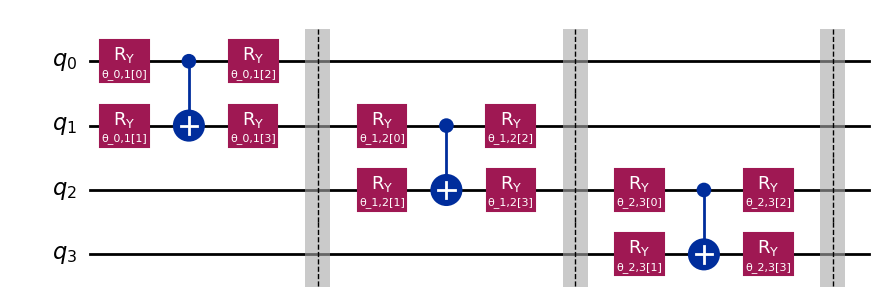

In [4]:
MPS(4, reps=1).decompose().draw('mpl')

In [8]:
n_train_samples = 50
n_test_samples = 1000

In [9]:
# Transformations
transformations = [transforms.ToTensor()]

# Train Dataset
# -------------

# Set train shuffle seed (for reproducibility)
manual_seed(seed)

# Use pre-defined torchvision function to load MNIST train data
X_train = datasets.MNIST(root="./data",
                         train=True,
                         download=True,
                         transform=transforms.Compose(transformations))

# Filter out labels (originally 0-9), leaving only labels 0 and 1
idx = np.append(
    np.where(X_train.targets == 3)[0][:n_train_samples],
    np.where(X_train.targets == 6)[0][:n_train_samples])

X_train.data = X_train.data[idx]
X_train.targets = 2 * (X_train.targets[idx] == 3) - 1

In [10]:
# Test Dataset
# -------------

# Use pre-defined torchvision function to load MNIST test data
X_test = datasets.MNIST(root="./data",
                        train=False,
                        download=True,
                        transform=transforms.Compose(transformations))

# Filter out labels (originally 0-9), leaving only labels 0 and 1
idx = np.append(
    np.where(X_test.targets == 3)[0][:n_test_samples],
    np.where(X_test.targets == 6)[0][:n_test_samples])

X_test.data = X_test.data[idx]
X_test.targets = 2 * (X_test.targets[idx] == 3) - 1

In [11]:
def display_images(images, rows, cols):
    """
    Display images in a grid layout using Matplotlib.

    Args:
        images (numpy.ndarray): Array of images with shape (batch_size, height, width).
        rows (int): Number of rows in the grid.
        cols (int): Number of columns in the grid.

    Returns:
        None
    """

    batch_size, height, width = images.shape

    fig, axes = plt.subplots(rows, cols, figsize=(8, 8))

    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i], cmap='gray')
        ax.axis('off')

#     plt.tight_layout()
    plt.show()

In [12]:
x_train = np.float32(X_train.data.numpy()) / 255.
y_train = X_train.targets.numpy()

x_test = np.float32(X_test.data.numpy()) / 255.
y_test = X_test.targets.numpy()

x_train, y_train = shuffle(x_train, y_train, random_state=42)
x_test, y_test = shuffle(x_test, y_test, random_state=42)

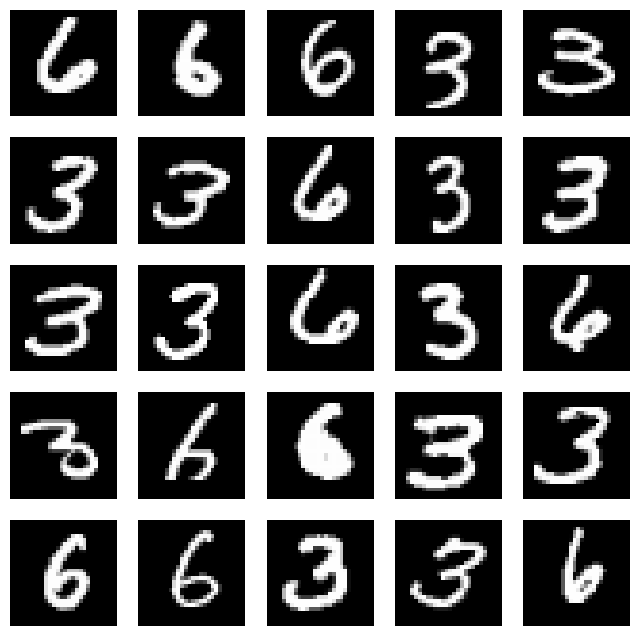

In [13]:
display_images(x_train, 5, 5)

In [14]:
x_train = x_train.reshape(-1, 28 * 28)
x_test = x_test.reshape(-1, 28 * 28)

pca = PCA(4)

x_train = pca.fit_transform(x_train)
cumsum = np.cumsum(pca.explained_variance_ratio_ * 100)[-1]
print("Cumulative sum on train :", cumsum)

x_test = pca.transform(x_test)
cumsum = np.cumsum(pca.explained_variance_ratio_ * 100)[-1]
print("Cumulative sum on train :", cumsum)

Cumulative sum on train : 47.31691
Cumulative sum on train : 47.31691


In [15]:
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)
print(x_train.max(), x_train.min())
print(x_test.max(), x_test.min())
print(y_train.max(), y_train.min())
print(y_test.max(), y_test.min())

(100, 4) (100,)
(1958, 4) (1958,)
6.5640445 -6.0287476
5.681618 -5.961256
1 -1
1 -1


In [16]:
x_train = np.arctan(x_train)
x_test = np.arctan(x_test)
print(x_train.max(), x_train.min(), x_train.mean())
print(x_test.max(), x_test.min(), x_test.mean())

1.4196137 -1.406421 0.02178444
1.3965745 -1.404594 -0.13202332


In [17]:
# Define and create QNN
def create_qnn(n, estimator=None, **kwargs):

    feature_map = QuantumCircuit(n)

    input_params = ParameterVector(name='x', length=n)

    for i in range(n):
        feature_map.ry(input_params[i], i)
        feature_map.rz(input_params[i], i)

    ansatz = MPS(n, reps=1, **kwargs).decompose()

    qc = QuantumCircuit(n)
    qc.compose(feature_map, inplace=True)
    qc.compose(ansatz, inplace=True)

    qnn = EstimatorQNN(estimator=estimator,
                       circuit=qc,
                       input_params=feature_map.parameters,
                       weight_params=ansatz.parameters)

    return qnn

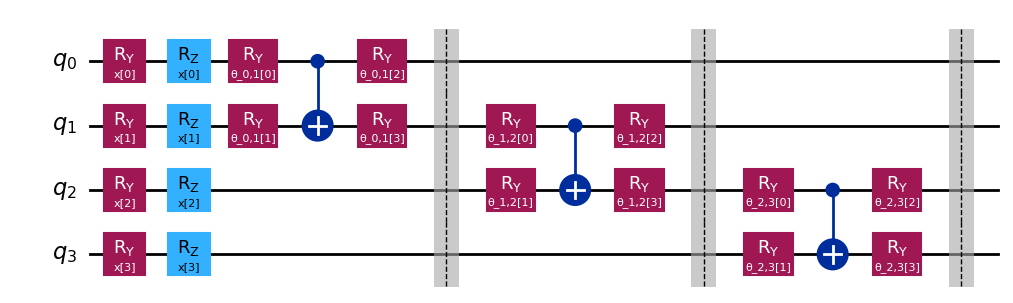

In [18]:
qnn = create_qnn(4, skip_final_rotation_layer=False)
qnn.circuit.draw('mpl', fold=1)

In [19]:
def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

In [23]:
# get a real backend from a real provider
service = QiskitRuntimeService(channel="ibm_quantum")
backend = service.backend("ibm_rensselaer")

# generate a simulator that mimics the real quantum system with the latest calibration results
backend_sim = AerSimulator.from_backend(backend)
noisy_estimator = BackendEstimator(backend_sim)

In [24]:
qnn = create_qnn(4, noisy_estimator, skip_final_rotation_layer=False)

initial_point = algorithm_globals.random.random(qnn.num_weights)

classifier = NeuralNetworkClassifier(
    qnn,
    optimizer=COBYLA(maxiter=100),  # Set max iterations here,
    callback=callback_graph,
    initial_point=initial_point,
)

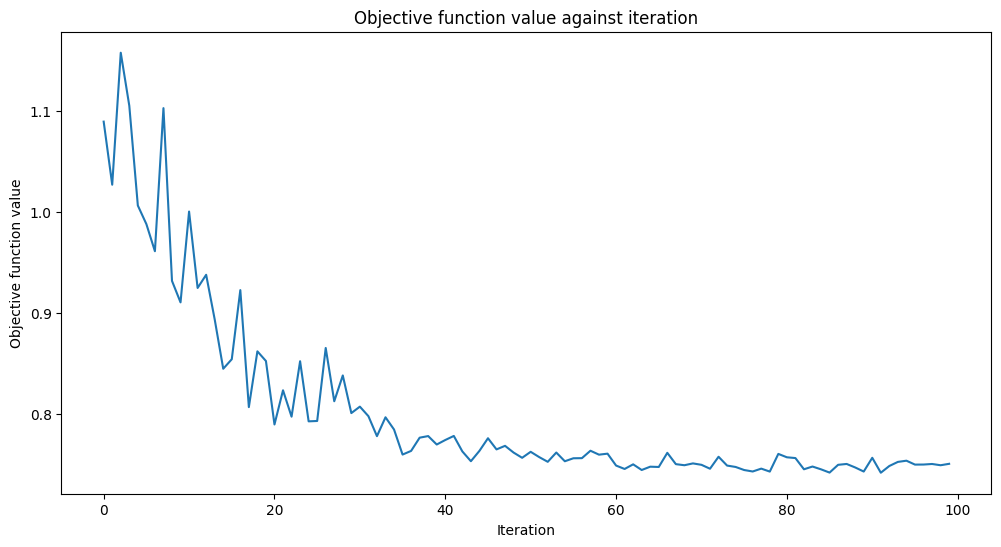

In [25]:
objective_func_vals = []

plt.rcParams["figure.figsize"] = (12, 6)
classifier.fit(x_train, y_train)

In [26]:
# score classifier
train_acc = np.round(100 * classifier.score(x_train, y_train), 4)
test_acc = np.round(100 * classifier.score(x_test, y_test), 4)

print(f"Accuracy from the train data : {train_acc}%")
print(f"Accuracy from the test data : {test_acc}%")

Accuracy from the train data : 80.0%
Accuracy from the test data : 74.7191%
